# Qiskit Workshop: Solving Optimization Problems

In [22]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService #, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

### Using IBM Runtime for cloud simulator and real hardware

In [38]:
from qiskit_ibm_runtime import Sampler as SamplerRT
from qiskit_ibm_runtime import Session

In [39]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

IBMQ.save_account("7d49cbf1c7fcc3040d25c16c77e5235594e8d87e314dba3b62ea44bb38b2770fa8c47acfa9985305e85764e304392cd032e35929688dea2bfbd41f6869ecb0c1")

provider = IBMQ.load_account()

least_busy_device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and 
                                        not x.configuration().simulator and x.status().operational==True))

least_busy_device

configrc.store_credentials:WARNING:2023-09-15 04:20:45,728: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-09-15 04:20:45,840: Credentials are already in use. The existing account in the session will be replaced.


<IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q', group='open', project='main')>

---

## Traveling Salesman Problem (TSP)

**Problem:** Consider a weighted graph where the edge weights denote the cost of moving along that edge. Compute the lowest-cost round-trip path that minimizes the total cost.

In [40]:
from qiskit_optimization.applications import Tsp
import networkx as nx
from qiskit.utils import algorithm_globals



import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems import QuadraticProgram
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np

def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 46. 88. 32.]
 [46.  0. 60. 68.]
 [88. 60.  0. 88.]
 [32. 68. 88.  0.]]


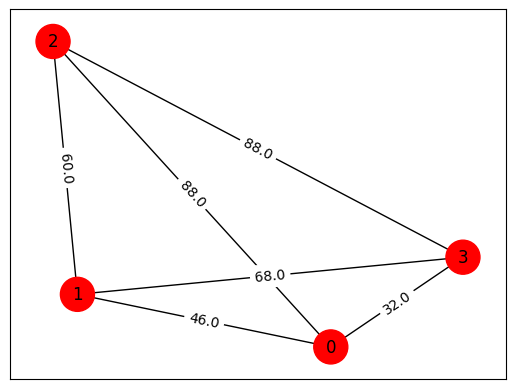

In [41]:
# Generating a random graph
n = 4
tsp = Tsp.create_random_instance(n,2,98, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print('distance\n', adj_matrix)

# Plot the graph
colors = ['r' for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]['pos']  for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

### Step 1: Convert TSP to quadratic program

In [42]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  46*x_0_0*x_1_1 + 46*x_0_0*x_1_3 + 88*x_0_0*x_2_1 + 88*x_0_0*x_2_3
  + 32*x_0_0*x_3_1 + 32*x_0_0*x_3_3 + 46*x_0_1*x_1_0 + 46*x_0_1*x_1_2
  + 88*x_0_1*x_2_0 + 88*x_0_1*x_2_2 + 32*x_0_1*x_3_0 + 32*x_0_1*x_3_2
  + 46*x_0_2*x_1_1 + 46*x_0_2*x_1_3 + 88*x_0_2*x_2_1 + 88*x_0_2*x_2_3
  + 32*x_0_2*x_3_1 + 32*x_0_2*x_3_3 + 46*x_0_3*x_1_0 + 46*x_0_3*x_1_2
  + 88*x_0_3*x_2_0 + 88*x_0_3*x_2_2 + 32*x_0_3*x_3_0 + 32*x_0_3*x_3_2
  + 60*x_1_0*x_2_1 + 60*x_1_0*x_2_3 + 68*x_1_0*x_3_1 + 68*x_1_0*x_3_3
  + 60*x_1_1*x_2_0 + 60*x_1_1*x_2_2 + 68*x_1_1*x_3_0 + 68*x_1_1*x_3_2
  + 60*x_1_2*x_2_1 + 60*x_1_2*x_2_3 + 68*x_1_2*x_3_1 + 68*x_1_2*x_3_3
  + 60*x_1_3*x_2_0 + 60*x_1_3*x_2_2 + 68*x_1_3*x_3_0 + 68*x_1_3*x_3_2
  + 88*x_2_0*x_3_1 + 88*x_2_0*x_3_3 + 88*x_2_1*x_3_0 + 88*x_2_1*x_3_2
  + 88*x_2_2*x_3_1 + 88*x_2_2*x_3_3 + 88*x_2_3*x_3_0 + 88*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

### Step 2: Construct solver

In [43]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA

def qaoa_callback(count, params, mean, metadata):
    if count % 10 == 0:
        print('Iteration:', count, ', value:', mean)
        
qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100), callback=qaoa_callback)
qaoa_meo = MinimumEigenOptimizer(qaoa)

In [45]:
with Session(service=service, backend='ibmq_qasm_simulator') as session:
    sampler_rt = SamplerRT(session=session)
    qaoa = QAOA(sampler=sampler_rt, optimizer=COBYLA(maxiter=100), callback=qaoa_callback)
    qaoa_meo = MinimumEigenOptimizer(qaoa)
    
    qaoa_result = qaoa_meo.solve(qp)
    
print(qaoa_result)

Iteration: 10 , value: (-8415.137999999999+0j)
Iteration: 20 , value: (264.66600000000045+0j)
Iteration: 30 , value: (-4925.853000000003+0j)
fval=248.0, x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=0.0, x_3_1=1.0, x_3_2=0.0, x_3_3=0.0, status=SUCCESS


### Step 3: Compute solution

In [ ]:
#qaoa_result = qaoa_meo.solve(qp)
#print(qaoa_result)

In [46]:
z = tsp.interpret(qaoa_result.x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, adj_matrix))

solution: [1, 3, 0, 2]
solution objective: 248.0


In [47]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

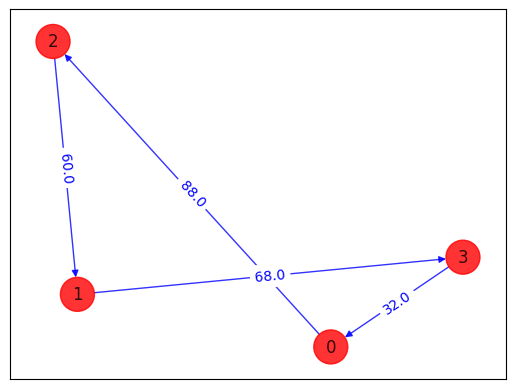

In [48]:
draw_tsp_solution(tsp.graph, z, colors, pos)

In [49]:
%qiskit_version_table